In [1]:
import pandas as pd
from textblob import TextBlob
import spacy
from collections import Counter
from tqdm import tqdm
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [ ]:
# Path to your Excel file
excel_file_path = '/content/Diabetes Geo US No Reddit 2023 50K rows.xlsx'

# Read the Excel file
df = pd.read_excel(excel_file_path)

# Drop columns that are completely null
cleaned_df = df.dropna(axis=1, how='all')

# Save to CSV
csv_file_path = 'cleaned_no_reddit.csv'
cleaned_df.to_csv(csv_file_path, index=False)

In [ ]:
nored = pd.read_csv('cleaned_no_reddit.csv')
nored.head()

<ipython-input-3-fa43243cd504>:1: DtypeWarning: Columns (20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  nored = pd.read_csv('cleaned_no_reddit.csv')


,Post ID,Sound Bite Text,Title,Source Type,Post Type,Is Paid,Media Type,URL,Media Link,Domain,...,Quoted Post,Quoted Author Name,Quoted Author Handle,Total Engagements,Post Comments,Post Likes,Post Shares,Reddit Score,Rating,Source Name
0,https://trapperman.com/forum/ubbthreads.php/to...,I take a low dose daily as counter to my metfo...,Warning for those who take Lisinopril - Trappe...,Forums,NaN,No,No Media,https://trapperman.com/forum/ubbthreads.php/to...,NaN,trapperman.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,NaN
1,1741463312586428562,@thisbttrfly @TheChiefNerd @SethMacFarlane Onl...,NaN,Twitter,Replies and Comments,No,No Media,http://twitter.com/MrShaveG/statuses/174146331...,NaN,twitter.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,NaN
2,https://www.city-data.com/forum/diabetes/34517...,Like clockwork it seems to start around 9pm in...,Nighttime burning itch,Forums,NaN,No,No Media,https://www.city-data.com/forum/diabetes/34517...,NaN,city-data.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,NaN
3,1741485119221674188,@HashCodeSalt @thesurepath1 I come from a medi...,NaN,Twitter,Replies and Comments,No,No Media,http://twitter.com/islam_supreme/statuses/1741...,NaN,twitter.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,NaN
4,https://community.whattoexpect.com/forums/may-...,Eww what a crappy doctor!!! If there was a blo...,Kinda freak out ? - May 2024 Babies | Forums |...,Forums,NaN,No,No Media,https://community.whattoexpect.com/forums/may-...,NaN,community.whattoexpect.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,NaN,NaN


In [ ]:
# Step 1: Load and Clean Data
df = pd.read_csv("/content/cleaned_no_reddit.csv")  # Replace with your file
df['text'] = df['Sound Bite Text'].fillna("") + " " + df['Title'].fillna("")

# Clean text
nlp = spacy.load("en_core_web_sm")
def preprocess(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())  # Remove non-alphabetic characters
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

df['cleaned_text'] = df['text'].apply(preprocess)

<ipython-input-8-eb0e60795efb>:9: DtypeWarning: Columns (20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/cleaned_no_reddit.csv")  # Replace with your file


In [ ]:
df.to_csv('nlped_no_reddit.csv')

In [ ]:
df = pd.read_csv('nlped_no_reddit.csv')
# Step 2: Topic Modeling
custom_stop_words = {"rt", "diabete", "diabetic", "diabetes", 'try', 'love', 'scene', 'cream', 'type', 'need', 'help'}  # Add more as needed

# Combine custom stop words with built-in English stop words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
combined_stop_words = list(ENGLISH_STOP_WORDS.union(custom_stop_words))

# Pass combined stop words to TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=combined_stop_words, max_df=0.95, min_df=2)
text_vectors = vectorizer.fit_transform(df['cleaned_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Adjust number of topics
lda.fit(text_vectors)

# Extract topics
def get_topics(model, feature_names, n_top_words):
    topics = {}
    for idx, topic in enumerate(model.components_):
        topics[idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return topics

topics = get_topics(lda, vectorizer.get_feature_names_out(), 10)

# Print topics
for topic, keywords in topics.items():
    print(f"Topic {topic}: {', '.join(keywords)}")

<ipython-input-43-0ffd4f43c70f>:1: DtypeWarning: Columns (21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('nlped_no_reddit.csv')


Topic 0: disease, cure, cancer, herbal, problem, herpe, stroke, kidney, hepatitis, medication
Topic 1: let, thank, insulin, pay, cat, biden, cost, president, today, year
Topic 2: like, insulin, hospital, episode, shoot, deserve, know, accident, sugar, tt
Topic 3: sugar, skin, healing, blood, covid, day, time, like, ve, dry
Topic 4: sugar, blood, eat, weight, like, baby, week, day, time, good


In [ ]:
# Step 3: Match Topics to Categories
categories = {
    "cost": ["cost", "price", "afford", "cap", "expense", "insulin"],
    "pharma_companies": ["pharma", "drug", "medication", "company", "prescription"],
    "government/public health agencies": ["biden", "president", "policy", "public", "covid"],
}

# Step 3: Match Topics to Categories
def assign_category(topic_index, topics, categories):
    """
    Match a topic index to a category based on the keywords of that topic.
    """
    # Get the keywords for the topic
    keywords = topics[topic_index]
    # Match the keywords to a category
    for category, words in categories.items():
        if any(word in keywords for word in words):
            return category
    return "other"

# Assign categories based on topics
df['topic'] = [
    assign_category(topic_idx, topics, categories)
    for topic_idx in lda.transform(text_vectors).argmax(axis=1)
]

In [ ]:
# Step 4: Count Conversations by Category
category_counts = df['topic'].value_counts()
# Save the results for inspection
output_path = 'No_Reddit_Category_Counts.csv'
category_counts.to_csv(output_path)
print(category_counts)

topic
other                                28283
cost                                 11910
government/public health agencies     5394
pharma_companies                      4424
Name: count, dtype: int64


In [2]:
# Load the cleaned Reddit data
file_path = '/content/Cleaned_Diabetes_Reddit_Data.csv'
red_df = pd.read_csv(file_path)

In [ ]:
# Step 1: Preprocess the text (already cleaned in the input)
red_df['text'] = red_df['Sound Bite Text'].fillna("") + " " + df['Title'].fillna("")

# Step 2: Define Topic Modeling using TF-IDF and LDA
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")
text_vectors = vectorizer.fit_transform(red_df['text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_vectors)

# Extract topics
def get_topics(model, feature_names, n_top_words=10):
    topics = {}
    for idx, topic in enumerate(model.components_):
        topics[idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return topics

topics = get_topics(lda, vectorizer.get_feature_names_out())

In [ ]:
# Print topics
for topic, keywords in topics.items():
    print(f"Topic {topic}: {', '.join(keywords)}")

Topic 0: diabetes, sugar, blood, like, just, insulin, weight, don, type, people
Topic 1: thank, ashwagandha, https, diabetes, natural, nessa, dec, simply, com, format
Topic 2: deleted, author, post, diabetes, album, com, healing, cream, forums, comments
Topic 3: diabetic, diabetes, just, like, don, know, insurance, time, got, ve
Topic 4: thanks, com, sugar, diabetes, https, www, use, libre, insulin, reddit


In [ ]:
# Step 3: Define categories for keyword matching
categories = {
    "cost": ["cost", "pay", "price", "expense", "afford", "insulin"],
    "pharma_companies": ["medication", "drug", "pharma", "cure", "hospital"],
    "government/public health agencies": ["biden", "policy", "public", "government", 'gov', 'institute', 'hospital', "covid", "agency"],
}

# Step 4: Assign a topic to each row and match to categories
red_df['topic'] = lda.transform(text_vectors).argmax(axis=1)
red_df['category'] = red_df['topic'].apply(lambda x: assign_category(x, topics, categories))

# Step 5: Count mentions for each category
category_counts = red_df['category'].value_counts()

# Save the results for inspection
output_path = 'Reddit_Category_Counts.csv'
category_counts.to_csv(output_path)

In [ ]:
category_counts

,count
category,
cost,20052
other,9372


In [ ]:
# Perform sentiment analysis on non red
def analyze_sentiment(text):
    """
    Analyze the sentiment of a given text using TextBlob.
    Returns polarity and subjectivity scores.
    """
    analysis = TextBlob(text)
    return analysis.polarity, analysis.subjectivity

# Apply sentiment analysis to each row
df[['polarity', 'subjectivity']] = df['text'].apply(lambda x: analyze_sentiment(x)).apply(pd.Series)

# Classify sentiment into positive, negative, or neutral
def classify_sentiment(polarity):
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

df['sentiment'] = df['polarity'].apply(classify_sentiment)

# Aggregate sentiment counts
sentiment_counts = df['sentiment'].value_counts()

# Save sentiment analysis results for inspection
output_sentiment_path = 'No_Reddit_Sentiment_Analysis.csv'
df.to_csv(output_sentiment_path, index=False)

output_sentiment_counts_path = 'No_Reddit_Sentiment_Counts.csv'
sentiment_counts.to_csv(output_sentiment_counts_path)

In [ ]:
sentiment_counts.head()

,count
sentiment,
positive,31445
negative,11774
neutral,6792


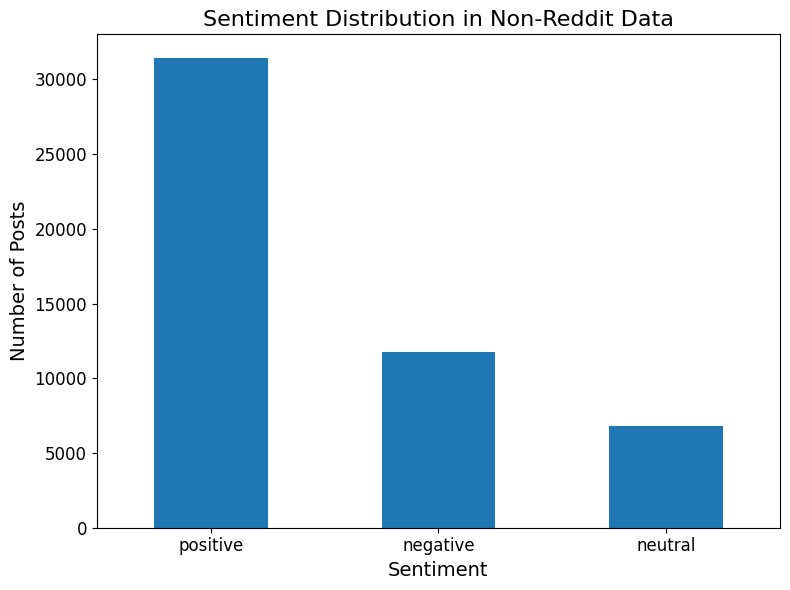

In [ ]:
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', rot=0)
plt.title('Sentiment Distribution in Non-Reddit Data', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Number of Posts', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [4]:
# Load llm sentiment output
llm = pd.read_csv('output.csv', encoding='latin1')

In [ ]:
# merge red with output of LLM to compare sentiment in detail
inner_merged_df = pd.merge(red_df, llm, on='Post ID', how='inner')

In [8]:
inner_merged_df = inner_merged_df[['Post ID', 'Sound Bite Text', 'Sentiment_x', 'Sentiment_y']]

In [10]:
filtered_df = inner_merged_df[
    ~(inner_merged_df['Sound Bite Text'].str.contains('Post deleted by the author.', na=False)) &
    ~(inner_merged_df['Post ID'].str.contains('Dec 31 2023 07:12:53 AM', na=False))
]

In [12]:
filtered_df

,Post ID,Sound Bite Text,Sentiment_x,Sentiment_y
0,BRDRDT2-t1_j2l7iop,I’ve had a non-diabetic A1C for a year without...,Neutrals,Unknown
331,BRDRDT2-t1_j9be3yh,"Unfortunately, we have no choice but to be tho...",Neutrals,Neutral
332,BRDRDT2-t1_jebcla3,„BuT yOu NeEd To EaT 70% cArBs AnD sNaCk To Ha...,Neutrals,Unknown
333,BRDRDT2-t3_11fapex,"Hi guys, I have burning hand, legs pins and ne...",Neutrals,Unknown
334,BRDRDT2-t1_j3eaxcp,Yeah you can get addicted even by touching it(...,Neutrals,Unknown
...,...,...,...,...
258121,BRDRDT2-t1_k4ntkf4,The medications work…but not for everyone. Som...,Neutrals,Unknown
258122,BRDRDT2-t1_kb0il5v,That sounds nice! Thanks for sharing :),Neutrals,Neutral
258123,BRDRDT2-t1_kcrid7f,wdym? sure this isn't the healthiest breakfast...,Neutrals,Unknown
258124,BRDRDT2-t1_ke603nl,no problem! the best time to quit is right now...,Neutrals,Unknown


In [13]:
different_sentiments_df = filtered_df[filtered_df['Sentiment_x'] != filtered_df['Sentiment_y']]
different_sentiments_df

,Post ID,Sound Bite Text,Sentiment_x,Sentiment_y
0,BRDRDT2-t1_j2l7iop,I’ve had a non-diabetic A1C for a year without...,Neutrals,Unknown
331,BRDRDT2-t1_j9be3yh,"Unfortunately, we have no choice but to be tho...",Neutrals,Neutral
332,BRDRDT2-t1_jebcla3,„BuT yOu NeEd To EaT 70% cArBs AnD sNaCk To Ha...,Neutrals,Unknown
333,BRDRDT2-t3_11fapex,"Hi guys, I have burning hand, legs pins and ne...",Neutrals,Unknown
334,BRDRDT2-t1_j3eaxcp,Yeah you can get addicted even by touching it(...,Neutrals,Unknown
...,...,...,...,...
258121,BRDRDT2-t1_k4ntkf4,The medications work…but not for everyone. Som...,Neutrals,Unknown
258122,BRDRDT2-t1_kb0il5v,That sounds nice! Thanks for sharing :),Neutrals,Neutral
258123,BRDRDT2-t1_kcrid7f,wdym? sure this isn't the healthiest breakfast...,Neutrals,Unknown
258124,BRDRDT2-t1_ke603nl,no problem! the best time to quit is right now...,Neutrals,Unknown
